# Pixel CNN on MNIST

In [ ]:
from dgm_utils import train_model, plot_training_curves
from dgm_utils import show_samples, visualize_images, load_pickle

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

USE_CUDA = torch.cuda.is_available()

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!gdown --id 1hExV0C8wQWsrA4HfRTq9y9rMo7Pjd9Gw

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1hExV0C8wQWsrA4HfRTq9y9rMo7Pjd9Gw
To: /content/mnist.pkl
100% 188M/188M [00:02<00:00, 64.8MB/s]


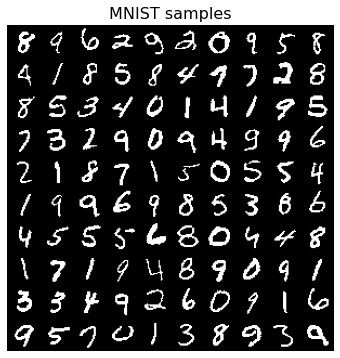

In [ ]:
train_data, test_data = load_pickle("/content/mnist.pkl", flatten=False, binarize=True)
visualize_images(train_data, "MNIST samples")

In [ ]:
class MaskedConv2d(nn.Conv2d):
    def __init__(self, mask_type, in_channels, out_channels, kernel_size=5):
        assert mask_type in ["A", "B"]
        super().__init__(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            padding=kernel_size // 2,
        )
        self.register_buffer("mask", torch.zeros_like(self.weight))
        self.create_mask(mask_type)

    def forward(self, input):
        self.weight.data = self.weight.data * self.mask
        return super(MaskedConv2d, self).forward(input)

    def create_mask(self, mask_type):
        height = self.weight.size()[2]
        width = self.weight.size()[3]

        if mask_type == "A":
            self.mask[:, :, height // 2 - 1, : width // 2] = 1
            self.mask[:, :, : height // 2 - 1, :] = 1
        else:
            self.mask[:, :, height // 2 - 1, : width // 2 + 1] = 1
            self.mask[:, :, : height // 2 + 1, :] = 1


def test_masked_conv2d():
    layer = MaskedConv2d("A", 2, 2)
    assert np.allclose(layer.mask[:, :, 2, 2].numpy(), np.zeros((2, 2)))

    layer = MaskedConv2d("B", 2, 2)
    assert np.allclose(layer.mask[:, :, 2, 2].numpy(), np.ones((2, 2)))


test_masked_conv2d()

In [ ]:
class LayerNorm(nn.LayerNorm):
    def __init__(self, n_filters):
        super().__init__(n_filters)

    def forward(self, x):
        x = x.permute(0, 2, 3, 1).contiguous()
        x = super().forward(x)
        return x.permute(0, 3, 1, 2).contiguous()

In [ ]:
class PixelCNN(nn.Module):
    def __init__(
        self,
        input_shape,
        n_filters=64,
        kernel_size=7,
        n_layers=5,
        use_layer_norm=True,
        hidden_size=16,
    ):
        super().__init__()
        self.input_shape = input_shape
        self.hidden_size = hidden_size

        self.MaskedConv1 = MaskedConv2d(
            "A", in_channels=1, out_channels=self.hidden_size, kernel_size=kernel_size
        )
        self.LN1 = LayerNorm(self.hidden_size)
        self.Relu = nn.ReLU(True)

        self.casual_layer = nn.Sequential(
            MaskedConv2d(
                "B", self.hidden_size, self.hidden_size, kernel_size=kernel_size
            ),
            # LayerNorm(self.hidden_size),
            nn.ReLU(True),
        )

        self.OutLayer = MaskedConv2d(
            "B", self.hidden_size, out_channels=2, kernel_size=kernel_size
        )

        self.casual_list = nn.ModuleList([self.casual_layer for i in range(n_layers)])

        self.net = nn.Sequential(
            self.MaskedConv1, self.LN1, self.Relu, *self.casual_list, self.OutLayer
        )

    def forward(self, x):
        batch_size = x.shape[0]
        out = (x.float() - 0.5) / 0.5
        out = self.net(out)
        return out.view(batch_size, 2, 1, *self.input_shape)

    def loss(self, x):
        output = self.forward(x)
        loss = nn.CrossEntropyLoss()
        total_loss = loss(output, x.long())

        return {"total_loss": total_loss}

    def sample(self, n):
        samples = torch.zeros(n, 1, *self.input_shape).cuda()
        with torch.no_grad():
            for r in range(self.input_shape[0]):
                for c in range(self.input_shape[1]):
                    logits = self(samples)[:, :, :, r, c]
                    probs = F.softmax(logits, dim=1).squeeze(-1)
                    samples[:, 0, r, c] = torch.multinomial(
                        probs, num_samples=1
                    ).squeeze(-1)
        return samples.cpu().numpy()

In [ ]:
EPOCHS = 15
BATCH_SIZE = 32
LR = 1e-3
N_LAYERS = 8
HIDDEN_SIZE = 64
USE_LAYER_NORM = True


model = PixelCNN(
    input_shape=(28, 28),
    kernel_size=5,
    n_layers=N_LAYERS,
    use_layer_norm=USE_LAYER_NORM,
    hidden_size=HIDDEN_SIZE,
)

loss = model.loss(torch.zeros(1, 1, 28, 28))
assert isinstance(loss, dict)
assert "total_loss" in loss

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE)
train_losses, test_losses = train_model(
    model,
    train_loader,
    test_loader,
    epochs=EPOCHS,
    lr=LR,
    use_tqdm=True,
    use_cuda=USE_CUDA,
)

assert test_losses["total_loss"][-1] < 0.10

  0%|          | 0/15 [00:00<?, ?it/s]

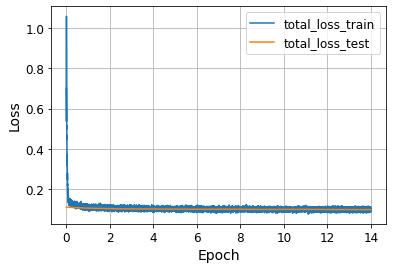

In [ ]:
plot_training_curves(train_losses, test_losses)

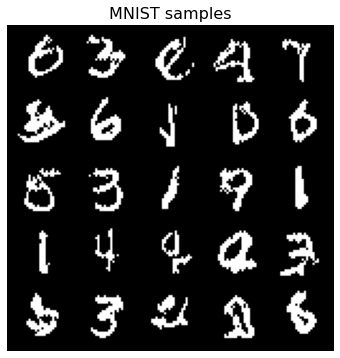

In [ ]:
samples = model.sample(25)
show_samples(samples, title="MNIST samples", nrow=5)

# Receptive Field and Image autocompletion

### Receptive field

Рассмотрим рецептивное поле, на что модель обращает внимание

In [ ]:
def plot_receptive_field(model, model_name):
    model = model.to("cpu")

    receptive = torch.zeros(1, 1, 28, 28)
    receptive.requires_grad = True

    out = model.forward(receptive)

    x_center = 14
    y_center = 14

    out[:, 0, :, x_center, y_center].backward()
    grad = receptive.grad

    binary_map = (grad > 1e-8).float()[0, 0, :, :]

    weighted_map = (grad / grad.max())[0, 0, :, :]

    binary_map = np.stack([binary_map, binary_map, binary_map], axis=-1)
    weighted_map = np.stack([weighted_map, weighted_map, weighted_map], axis=-1)

    binary_map[x_center, y_center] = [1, 0, 0]
    weighted_map[x_center, y_center] = [1, 0, 0]

    fig, ax = plt.subplots(1, 2, figsize=(10, 6))
    ax[0].imshow(weighted_map, vmin=0.0, vmax=1.0)
    ax[1].imshow(binary_map, vmin=0.0, vmax=1.0)

    ax[0].set_title(f"Weighted receptive field for {model_name}")
    ax[1].set_title(f"Binary receptive field for {model_name}")

    ax[0].axis("off")
    ax[1].axis("off")
    plt.show()
    return binary_map

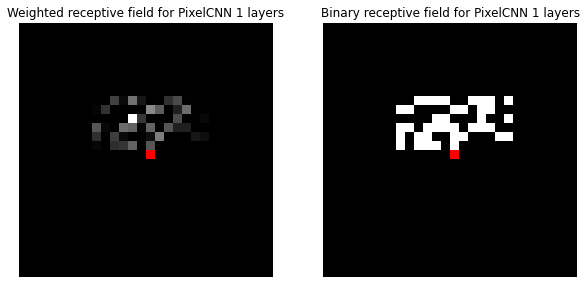

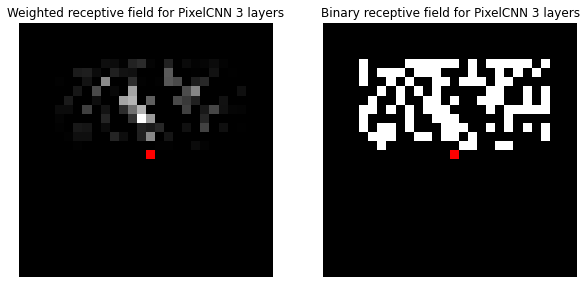

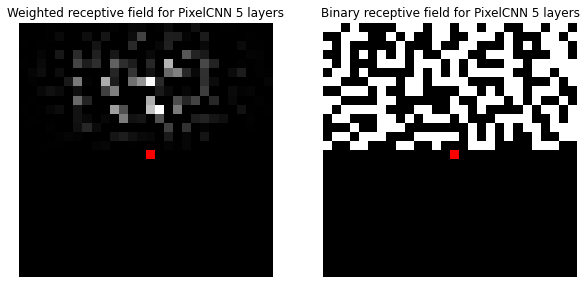

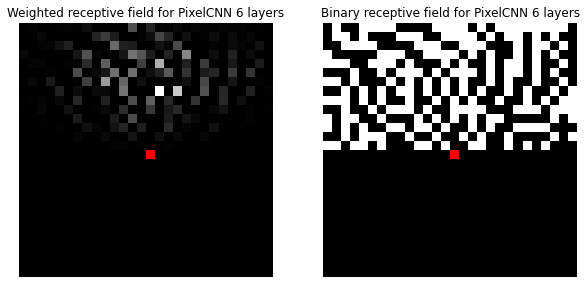

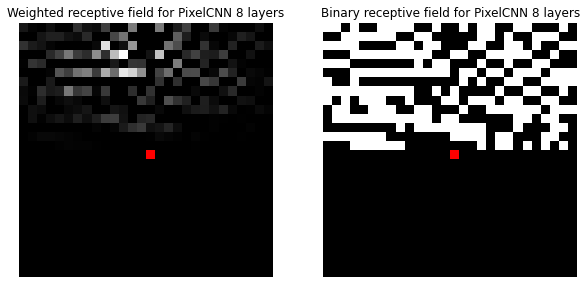

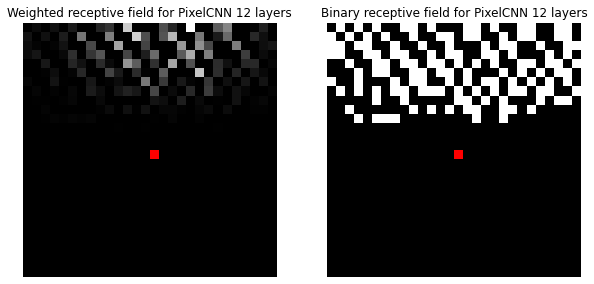

In [ ]:
for n_layers in [1, 3, 5, 6, 8, 12]:
    model = PixelCNN(
        input_shape=(28, 28),
        n_filters=32,
        kernel_size=5,
        n_layers=n_layers,
        use_layer_norm=True,
    )

    plot_receptive_field(model, model_name=f"PixelCNN {n_layers} layers")



Можем заметить, что есть странное слепое пятно справа. Как выяснилось, это известная проблема данной модели, которая решается следующей ее версией [GatedPixelCNN](https://arxiv.org/pdf/1606.05328.pdf)

### Image autocompletion

А теперь рассмотрим, как наша модель умеет достраивать изображения

In [ ]:
class PixelCNNAutoComplete(PixelCNN):
    def sample(self, n, init=None):
        if init is None:
            return super(PixelCNNAutoComplete, self).sample(n)

        else:
            samples = init
            with torch.no_grad():
                for r in range(self.input_shape[0]):
                    for c in range(self.input_shape[1]):
                        # return samples
                        if samples[0, :, r, c] == -1:
                            logits = self(samples)[:, :, :, r, c]
                            probs = F.softmax(logits, dim=1).squeeze(-1)
                            samples[:, 0, r, c] = torch.multinomial(
                                probs, num_samples=1
                            ).squeeze(-1)
            return samples.cpu().numpy()

You have to repeat the model training.

In [ ]:
EPOCHS = 15
BATCH_SIZE = 32
LR = 1e-3
N_LAYERS = 8
HIDDEN_SIZE = 64
USE_LAYER_NORM = True


model = PixelCNNAutoComplete(
    input_shape=(28, 28),
    hidden_size=HIDDEN_SIZE,
    kernel_size=5,
    n_layers=N_LAYERS,
    use_layer_norm=USE_LAYER_NORM,
)

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE)
train_losses, test_losses = train_model(
    model,
    train_loader,
    test_loader,
    epochs=EPOCHS,
    lr=LR,
    use_tqdm=True,
    use_cuda=USE_CUDA,
)

assert test_losses["total_loss"][-1] < 0.10

  0%|          | 0/15 [00:00<?, ?it/s]

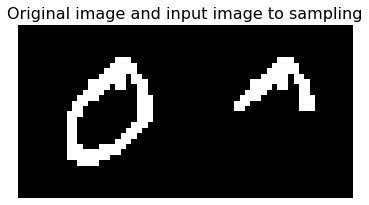

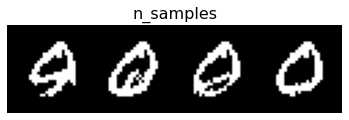

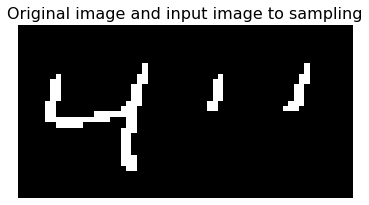

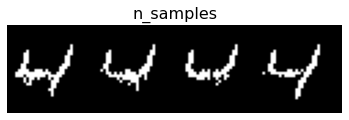

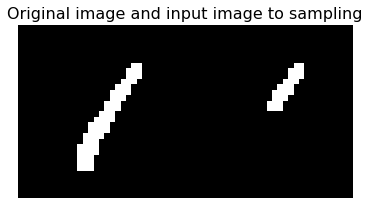

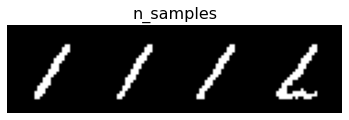

In [ ]:
def autocomplete_image(image, model, n_samples):
    image_init = image.copy()
    image_init[:, image.shape[1] // 2 :, :] = -1
    samples = np.stack([image, np.maximum(image_init, 0)])
    show_samples(samples, title="Original image and input image to sampling", nrow=2)

    image_init = torch.tensor(image_init)
    image_init = image_init.unsqueeze(dim=0).expand(n_samples, -1, -1, -1).cuda()

    img_generated = model.sample(n_samples, image_init)

    show_samples(img_generated, title="n_samples", nrow=4)


for i in range(1, 4):
    autocomplete_image(train_data[i], model, n_samples=4)